# Intro. to Snorkel: Extracting Spouse Relations from the News

## Part II: Generating _and modeling_ noisy training labels

In this part of the tutorial, we will write **labeling functions** which express various heuristics, patterns, and [_weak supervision_](http://hazyresearch.github.io/snorkel/blog/weak_supervision.html) strategies to label our data.

In most real-world settings, hand-labeled training data is prohibitively expensive and slow to collect. A common scenario, though, is to have access to tons of _unlabeled_ training data, and have some idea of how to label it programmatically. For example:

* We may be able to think of text patterns that would indicate two people mentioned in a sentence are married, such as seeing the word "spouse" between the mentions.
* We may have access to an external _knowledge base (KB)_ that lists some known pairs of married people, and can use these to heuristically label some subset of our data.

Our labeling functions will capture these types of strategies. We know that these labeling functions will not be perfect, and some may be quite low-quality, so we will _model_ their accuracies with a generative model, which Snorkel will help us easily apply.

This will ultimately produce a single set of **noise-aware training labels**, which we will then use to train an end extraction model in the next notebook.  For more technical details of this overall approach, see our [NIPS 2016 paper](https://arxiv.org/abs/1605.07723).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
# os.environ['SNORKELDB'] = 'postgres:///snorkel-intro'

import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

We repeat our definition of the `Spouse` `Candidate` subclass from Parts II and III.

In [2]:
from snorkel.models import candidate_subclass

Spouse = candidate_subclass('Spouse', ['person1', 'person2'])

### Using a labeled _development set_

In our setting here, we will use the phrase "development set" to refer to a _small_ set of examples (here, a subset of our training set) which we label by hand and use to help us develop and refine labeling functions. Unlike the _test set_, which we do not look at and use for final evaluation, we can inspect the development set while writing labeling functions.

In our case, we already loaded existing labels for a development set (`split` 1), so we can load them again now:

In [3]:
from snorkel.annotations import load_gold_labels

L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)

# Creating and Modeling a Noisy Training Set

Our biggest step in the data programming pipeline is the creation - _and modeling_ - of a noisy training set.  We'll approach this in three main steps:

1. **Creating labeling functions (LFs):** This is where most of our development time would actually go into if this were a real application. Labeling functions encode our heuristics and weak supervision signals to generate (noisy) labels for our training candidates.

2. **Applying the LFs:** Here, we actually use them to label our candidates!

3. **Training a generative model of our training set:** Here we learn a model over our LFs, learning their respective accuracies automatically. This will allow us to combine them into a single, higher-quality label set.

We'll also add some detail on how to go about _developing labeling functions_ and then _debugging our model_ of them to improve performance.

## 1. Creating Labeling Functions

In Snorkel, our primary interface through which we provide training signal to the end extraction model we are training is by writing **labeling functions (LFs)** (as opposed to hand-labeling massive training sets).  We'll go through some examples for our spouse extraction task below.

A labeling function is just a Python function that accepts a `Candidate` and returns `1` to mark the `Candidate` as true, `-1` to mark the `Candidate` as false, and `0` to abstain from labeling the `Candidate` (note that the non-binary classification setting is covered in the advanced tutorials!).

In the next stages of the Snorkel pipeline, we'll train a model to learn the accuracies of the labeling functions and trewieght them accordingly, and then use them to train a downstream model. It turns out by doing this, we can get high-quality models even with lower-quality labeling functions. So they don't need to be perfect! Now on to writing some:

In [6]:
import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,
)

Instructions for updating:
Use the retry module or similar alternatives.


### Pattern-based LFs
These LFs express some common sense text patterns which indicate that a person pair might be married. For example, `LF_husband_wife` looks for words in `spouses` between the person mentions, and `LF_same_last_name` checks to see if the two people have the same last name (but aren't the same whole name).

In [7]:
spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}
family = {'father', 'mother', 'sister', 'brother', 'son', 'daughter',
              'grandfather', 'grandmother', 'uncle', 'aunt', 'cousin'}
family = family | {f + '-in-law' for f in family}
other = {'boyfriend', 'girlfriend' 'boss', 'employee', 'secretary', 'co-worker'}

# Helper function to get last name
def last_name(s):
    name_parts = s.split(' ')
    return name_parts[-1] if len(name_parts) > 1 else None    

def LF_husband_wife(c):
    return 1 if len(spouses.intersection(get_between_tokens(c))) > 0 else 0

def LF_husband_wife_left_window(c):
    if len(spouses.intersection(get_left_tokens(c[0], window=2))) > 0:
        return 1
    elif len(spouses.intersection(get_left_tokens(c[1], window=2))) > 0:
        return 1
    else:
        return 0
    
def LF_same_last_name(c):
    p1_last_name = last_name(c.person1.get_span())
    p2_last_name = last_name(c.person2.get_span())
    if p1_last_name and p2_last_name and p1_last_name == p2_last_name:
        if c.person1.get_span() != c.person2.get_span():
            return 1
    return 0

def LF_no_spouse_in_sentence(c):
    return -1 if np.random.rand() < 0.75 and len(spouses.intersection(c.get_parent().words)) == 0 else 0

def LF_and_married(c):
    return 1 if 'and' in get_between_tokens(c) and 'married' in get_right_tokens(c) else 0
    
def LF_familial_relationship(c):
    return -1 if len(family.intersection(get_between_tokens(c))) > 0 else 0

def LF_family_left_window(c):
    if len(family.intersection(get_left_tokens(c[0], window=2))) > 0:
        return -1
    elif len(family.intersection(get_left_tokens(c[1], window=2))) > 0:
        return -1
    else:
        return 0

def LF_other_relationship(c):
    return -1 if len(other.intersection(get_between_tokens(c))) > 0 else 0

### Distant Supervision LFs

In addition to writing labeling functions that describe text pattern-based heuristics for labeling training examples, we can also write labeling functions that distantly supervise examples. Here, we'll load in a list of known spouse pairs and check to see if the candidate pair matches one of these.

In [8]:
import bz2

# Function to remove special characters from text
def strip_special(s):
    return ''.join(c for c in s if ord(c) < 128)

# Read in known spouse pairs and save as set of tuples
with bz2.BZ2File('data/spouses_dbpedia.csv.bz2', 'rb') as f:
    known_spouses = set(
        tuple(strip_special(x.decode('utf-8')).strip().split(',')) for x in f.readlines()
    )
# Last name pairs for known spouses
last_names = set([(last_name(x), last_name(y)) for x, y in known_spouses if last_name(x) and last_name(y)])
    
def LF_distant_supervision(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    return 1 if (p1, p2) in known_spouses or (p2, p1) in known_spouses else 0

def LF_distant_supervision_last_names(c):
    p1, p2 = c.person1.get_span(), c.person2.get_span()
    p1n, p2n = last_name(p1), last_name(p2)
    return 1 if (p1 != p2) and ((p1n, p2n) in last_names or (p2n, p1n) in last_names) else 0

For later convenience we group the labeling functions into a list.

In [9]:
LFs = [
    LF_distant_supervision, LF_distant_supervision_last_names, 
    LF_husband_wife, LF_husband_wife_left_window, LF_same_last_name,
    LF_no_spouse_in_sentence, LF_and_married, LF_familial_relationship, 
    LF_family_left_window, LF_other_relationship
]

### Developing Labeling Functions

Above, we've written a bunch of labeling functions already, which should give you some sense about how to go about it. While writing them, we probably want to check to make sure that they at least work as intended before adding to our set. Suppose we're thinking about writing a simple LF: 

In [10]:
def LF_wife_in_sentence(c):
    """A simple example of a labeling function"""
    return 1 if 'wife' in c.get_parent().words else 0

One simple thing we can do is quickly test it on our development set (or any other set), without saving it to the database.  This is simple to do. For example, we can easily get every candidate that this LF labels as true:

In [103]:
labeled = []
for c in session.query(Spouse).filter(Spouse.split == 1).all():
    if LF_wife_in_sentence(c) != 0:
        labeled.append(c)
print("Number labeled:", len(labeled))

Number labeled: 278


We can then easily put this into the Viewer as usual (try it out!):
```
SentenceNgramViewer(labeled, session)
```

We also have a simple helper function for getting the empirical accuracy of a single LF with respect to the development set labels for example. This function also returns the evaluation buckets of the candidates (true positive, false positive, true negative, false negative):

In [104]:
from snorkel.lf_helpers import test_LF
tp, fp, tn, fn = test_LF(session, LF_wife_in_sentence, split=1, annotator_name='gold')

Scores (Un-adjusted)
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Precision            0.235
Recall               1.0
F1                   0.38
----------------------------------------
TP: 62 | FP: 202 | TN: 0 | FN: 0



## 2. Applying the Labeling Functions

Next, we need to actually run the LFs over all of our training candidates, producing a set of `Labels` and `LabelKeys` (just the names of the LFs) in the database.  We'll do this using the `LabelAnnotator` class, a UDF which we will again run with `UDFRunner`.  **Note that this will delete any existing `Labels` and `LabelKeys` for this candidate set.**  We start by setting up the class:

In [11]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

Finally, we run the `labeler`. Note that we set a random seed for reproducibility, since some of the LFs involve random number generators. Again, this can be run in parallel, given an appropriate database like Postgres is being used:

In [105]:
np.random.seed(1701)
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 28s, sys: 444 ms, total: 1min 28s
Wall time: 2min 10s


<22276x10 sparse matrix of type '<class 'numpy.int64'>'
	with 22305 stored elements in Compressed Sparse Row format>

In [312]:
np.random.seed(1701)
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 32s, sys: 496 ms, total: 1min 32s
Wall time: 2min 31s


<22276x10 sparse matrix of type '<class 'numpy.int64'>'
	with 22305 stored elements in Compressed Sparse Row format>

If we've already created the labels (saved in the database), we can load them in as a sparse matrix here too:

In [12]:
%time L_train = labeler.load_matrix(session, split=0)
L_train

CPU times: user 136 ms, sys: 4 ms, total: 140 ms
Wall time: 485 ms


<22276x10 sparse matrix of type '<class 'numpy.int64'>'
	with 22287 stored elements in Compressed Sparse Row format>

Note that the returned matrix is a special subclass of the `scipy.sparse.csr_matrix` class, with some special features which we demonstrate below:

In [14]:
L_train.get_candidate(session, 0)

Spouse(Span("Broken", sentence=16781, chars=[0,5], words=[0,0]), Span("Arthur", sentence=16781, chars=[16,21], words=[3,3]))

In [15]:
L_train.get_key(session, 0)

LabelKey (LF_distant_supervision)

We can also view statistics about the resulting label matrix.

* **Coverage** is the fraction of candidates that the labeling function emits a non-zero label for.
* **Overlap** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a non-zero label for.
* **Conflict** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a *conflicting* non-zero label for.

In [16]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_distant_supervision,0,0.001438,0.001438,0.000584
LF_distant_supervision_last_names,1,0.008043,0.007909,0.004539
LF_husband_wife,2,0.104655,0.066819,0.017974
LF_husband_wife_left_window,3,0.077964,0.057832,0.010785
LF_same_last_name,4,0.016716,0.014739,0.009481
LF_no_spouse_in_sentence,5,0.602723,0.080974,0.009122
LF_and_married,6,0.000674,0.000539,0.000449
LF_familial_relationship,7,0.104386,0.092028,0.021434
LF_family_left_window,8,0.073380,0.066954,0.012088
LF_other_relationship,9,0.009347,0.006650,0.001123


In [107]:
%time L_dev = labeler.load_matrix(session, split=1)
L_dev

CPU times: user 76 ms, sys: 0 ns, total: 76 ms
Wall time: 78.8 ms


<2814x10 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>

In [13]:
%time L_dev = labeler.apply_existing(split=1)
L_dev

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 15.1 s, sys: 100 ms, total: 15.2 s
Wall time: 26.9 s


<2814x10 sparse matrix of type '<class 'numpy.int64'>'
	with 2874 stored elements in Compressed Sparse Row format>

In [43]:
print(L_train.shape)
print(L_dev.shape)
print(L_train.key_index)
for x in vars(L_train):
    print(x,type(x))

(22276, 0)
(2814, 0)
{}
key_index <class 'str'>
annotation_key_cls <class 'str'>
_shape <class 'str'>
indices <class 'str'>
maxprint <class 'str'>
indptr <class 'str'>
col_index <class 'str'>
data <class 'str'>
candidate_index <class 'str'>
row_index <class 'str'>


In [47]:
dev_cands   = session.query(Spouse).filter(Spouse.split == 1).order_by(Spouse.id).all()
for i,_ in enumerate(dev_cands):
    c = L_dev.get_candidate(session,i)
#     print(c,type(c))
    ri = L_dev.get_row_index(c)
#     print(ri,type(ri))
   
#     print(L_dev.col_index)
#     print(L_dev.candidate_index)
# #     keyofcolj = L_dev.get_key(session,0)
# #     print(key0fcolj,type(keyofcolj))

(2814, 0)


In [14]:
L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1, zero_one=True)
gold_labels_dev = [L[0,0] if L[0,0]==1 else -1 for L in L_gold_dev]
# for i,L in enumerate(L_gold_dev):
#     print(L,gold_labels_dev[i])

In [15]:
def get_L_S_Tensor(cands,msg):     
    L_S = []
    print('labelling ',msg,' data')
    for i,c in enumerate(cands):
        L_S_ci=[]
        L=[]
        S=[]
        P_ik = []
        for LF in LFs:
#             print(i,LF.__name__)            
            l = LF(c)
            s = 0
            L.append(l)
            S.append((s+1)/2)  #to scale scores in [0,1] 
        L_S_ci.append(L)
        L_S_ci.append(S)
        L_S.append(L_S_ci) 
 
    return L_S

In [17]:
import _pickle as pkl
dev_cands   = session.query(Spouse).filter(Spouse.split == 1).order_by(Spouse.id).all()

dev_L_S = get_L_S_Tensor(dev_cands,'descrete lfs')
pkl.dump(dev_L_S,open("dev_L_S.p","wb"))



labelling  descrete lfs  data


In [18]:
import math
import pandas as pd
# test_L_S_df.mode(axis=1)[0].tolist()
LF_Names = [x.__name__ for x in LFs]
dev_L_S_df = pd.DataFrame((np.array(dev_L_S)[:,0,:]),columns=LF_Names)
# test_L_S_df = test_L_S_df.astype(int)

dev_L_S_df = dev_L_S_df.replace(0, np.NaN)
dev_L_S_df

,LF_distant_supervision,LF_distant_supervision_last_names,LF_husband_wife,LF_husband_wife_left_window,LF_same_last_name,LF_no_spouse_in_sentence,LF_and_married,LF_familial_relationship,LF_family_left_window,LF_other_relationship
0,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,-1.0,-1.0,NaN
1,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0
5,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
7,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,-1.0
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN


In [22]:
from sklearn.metrics import precision_recall_fscore_support
predicted_labels=dev_L_S_df.mode(axis=1)[0].tolist()
# print(predicted_labels)
predicted_labels = [ int(x) if not math.isnan(x) else 1 for x in predicted_labels ]
print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average="binary"))
Results = predictAndPrint(gold_labels_dev,predicted_labels)
Results

(0.14365256124721604, 0.6825396825396826, 0.23735050597976082, None)
acc 0.7054015636105189


,f1-score,precision,recall,support
-1,0.82,0.97,0.71,2625.0
1,0.24,0.14,0.68,189.0
avg / total,0.78,0.91,0.71,2814.0


In [23]:
predicted_labels=dev_L_S_df.mode(axis=1)[0].tolist()
# print(predicted_labels)
predicted_labels = [ int(x) if not math.isnan(x) else -1 for x in predicted_labels ]
MajLabels = predicted_labels
print(precision_recall_fscore_support(np.array(gold_labels_dev),np.array(predicted_labels),average="binary"))

Results = predictAndPrint(gold_labels_dev,predicted_labels)
Results

(0.3626760563380282, 0.544973544973545, 0.4355179704016914, None)
acc 0.9051172707889126


,f1-score,precision,recall,support
-1,0.95,0.97,0.93,2625.0
1,0.44,0.36,0.54,189.0
avg / total,0.91,0.93,0.91,2814.0


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

def report2dict(cr):
    # Parse rows
    tmp = list()
    for row in cr.split("\n"):
        parsed_row = [x for x in row.split("  ") if len(x) > 0]
        if len(parsed_row) > 0:
            tmp.append(parsed_row)
    
    # Store in dictionary
    measures = tmp[0]

    D_class_data = defaultdict(dict)
    for row in tmp[1:]:
        class_label = row[0]
        for j, m in enumerate(measures):
            D_class_data[class_label][m.strip()] = float(row[j + 1].strip())
    return pd.DataFrame(D_class_data).T

def predictAndPrint(true_labels,pl):
    print("acc",accuracy_score(true_labels,pl))
#     print(precision_recall_fscore_support(true_labels,pl,average='macro'))
#     draw2DArray(confusion_matrix(true_labels,pl))
    return report2dict(classification_report(true_labels, pl))#, target_names=['+1','-1']))
    

## 3. Fitting the Generative Model
Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

In [109]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [18]:
#before running
gen_model.weights.lf_accuracy

array([ 0.07472098,  0.07514459,  0.11910277,  0.11186369,  0.07306518,
        0.69216714,  0.07467749,  0.16012659,  0.13682546,  0.08183363])

In [111]:
gen_model.weights.lf_accuracy

array([0.07593892, 0.07371081, 0.12106188, 0.11385581, 0.07111215,
       0.69720609, 0.07364145, 0.15895311, 0.13735555, 0.08185791])

We now apply the generative model to the training candidates to get the noise-aware training label set. We'll refer to these as the training marginals:

In [112]:
train_marginals = gen_model.marginals(L_train)

We'll look at the distribution of the training marginals:

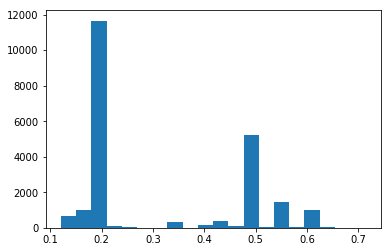

In [113]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

We can view the learned accuracy parameters, and other statistics about the LFs learned by the generative model:

In [114]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.534284,0.6665,0.541899,0.361443
1,0.531301,0.6693,0.538393,0.357521
2,0.565989,0.6645,0.575229,0.381643
3,0.566398,0.6702,0.575776,0.378506
4,0.544074,0.6716,0.554714,0.358894
5,0.798295,0.7154,0.806150,0.575799
6,0.526449,0.6711,0.536130,0.343401
7,0.578727,0.6675,0.589528,0.384193
8,0.567547,0.6662,0.572035,0.369876
9,0.541057,0.6698,0.551551,0.366150


### Using the Model to Iterate on Labeling Functions

Now that we have learned the generative model, we can stop here and use this to potentially debug and/or improve our labeling function set.  First, we apply the LFs to our development set:

In [115]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



And finally, we get the score of the generative model:

In [116]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.55
Neg. class accuracy: 0.929
Precision            0.357
Recall               0.55
F1                   0.433
----------------------------------------
TP: 104 | FP: 187 | TN: 2438 | FN: 85



In [283]:
dev_marginals = gen_model.marginals(L_dev)
def get_predict_labels(marginals):
    predicted_labels=[]
    for i in marginals:
        if(i<=0.5):
            predicted_labels.append(-1)
        else:
            predicted_labels.append(1)
    return predicted_labels
GenLabels = get_predict_labels(dev_marginals)

# for i,c in enumerate(dev_cands):
#     print(GenLabels[i],MajLabels[i],gold_labels_dev[i])

In [290]:
predicted_labels = [ int(x) if not math.isnan(x) else 1 for x in predicted_labels ]

Results = predictAndPrint(gold_labels_dev,GenLabels)
Results

acc 0.9033404406538735


,f1-score,precision,recall,support
-1,0.95,0.97,0.93,2625.0
1,0.43,0.36,0.55,189.0
avg / total,0.91,0.93,0.90,2814.0


In [201]:
cols = dev_L_S_df.columns
bt = dev_L_S_df.apply(lambda x: x == -1)
bt.apply(lambda x: list(cols[x.values]), axis=1)
LF_distant_supervision, LF_distant_supervision_last_names, 
    LF_husband_wife, LF_husband_wife_left_window, LF_same_last_name,
    LF_no_spouse_in_sentence, LF_and_married, LF_familial_relationship, 
    LF_family_left_window, LF_other_relationship

0                                    [0.6972060941200195]
1                                    [0.6972060941200195]
2                                    [0.6972060941200195]
3              [0.12106187999004792, 0.11385580962174358]
4                                                      []
5              [0.12106187999004792, 0.11385580962174358]
6                                    [0.6972060941200195]
7                                    [0.6972060941200195]
8                                    [0.6972060941200195]
9                                    [0.6972060941200195]
10                                   [0.6972060941200195]
11                                   [0.6972060941200195]
12                                   [0.6972060941200195]
13                                   [0.6972060941200195]
14                                   [0.6972060941200195]
15                                   [0.6972060941200195]
16                                                     []
17            

In [198]:
gen_model.weights.lf_accuracy[pd.Series([True,False,True,False,False,False,False,False,False,False]).values]
# cols[pd.Series([True,False,True,False,False,False,False,False,False,False]).values]

array([0.07593892, 0.12106188])

In [285]:
GenVsMaj_df = pd.DataFrame({'GenLabel':GenLabels,'MajLabel':MajLabels,'True':gold_labels_dev,'Marginals':dev_marginals})
GenVsMaj_df["Gen"]=GenVsMaj_df["GenLabel"]==GenVsMaj_df["True"]
GenVsMaj_df["Maj"]=GenVsMaj_df["MajLabel"]==GenVsMaj_df["True"]
GenVsMaj_df

,GenLabel,MajLabel,Marginals,True,Gen,Maj
0,-1,-1,0.198704,-1,True,True
1,-1,-1,0.500000,-1,True,True
2,-1,-1,0.198704,-1,True,True
3,1,1,0.615345,-1,False,False
4,-1,-1,0.500000,-1,True,True
5,1,1,0.615345,1,True,True
6,-1,-1,0.198704,-1,True,True
7,-1,-1,0.198704,-1,True,True
8,-1,-1,0.500000,-1,True,True
9,-1,-1,0.198704,-1,True,True


In [270]:
dev_L_S_df = dev_L_S_df.replace(np.NaN, 0)
# dev_L_S_df
# wts = dev_L_S_df.apply(lambda x: x != 0)
wts
# for d,w in zip(dev_L_S_df['LF_distant_supervision'],wts['LF_distant_supervision']):
#     print(d,w)
   
# wts = wts.apply(lambda x: list(gen_model.weights.lf_accuracy[x.values]), axis=1)
# counts = dev_L_S_df.apply(lambda x : x.value_counts() , axis = 1)
# counts['nnz'] = counts.count(axis=1)/len(LFs)
# counts['nnzindices'] = wts
# GenVsMaj_df = GenVsMaj_df.join(counts)
# counts

0                                    [0.6972060941200195]
1                                    [0.6972060941200195]
2                                    [0.6972060941200195]
3                                                      []
4                                                      []
5              [0.12106187999004792, 0.11385580962174358]
6                                    [0.6972060941200195]
7                                    [0.6972060941200195]
8                                    [0.6972060941200195]
9                                    [0.6972060941200195]
10                                   [0.6972060941200195]
11                                   [0.6972060941200195]
12                                   [0.6972060941200195]
13                                   [0.6972060941200195]
14                                   [0.6972060941200195]
15                                   [0.6972060941200195]
16                                                     []
17            

In [295]:
GenVsMaj_df = GenVsMaj_df.join(counts)
res = GenVsMaj_df[(GenVsMaj_df["GenLabel"] != GenVsMaj_df["True"]) & (GenVsMaj_df["MajLabel"]==GenVsMaj_df["True"]) ]
# res = res[(res['Marginals']<0.6)]
res = res[(res[-1]-res[1])<=1]
print(len(res))
res.to_csv("res.csv")
res

12


,GenLabel,MajLabel,Marginals,True,Gen,Maj,-1.0,0.0,1.0,nnz
141,1,-1,0.535496,-1,False,True,1.0,8.0,1.0,0.3
230,-1,1,0.248848,1,False,True,1.0,7.0,2.0,0.3
713,1,-1,0.535496,-1,False,True,1.0,8.0,1.0,0.3
1021,1,-1,0.535496,-1,False,True,1.0,8.0,1.0,0.3
1839,1,-1,0.560237,-1,False,True,1.0,8.0,1.0,0.3
1840,1,-1,0.560237,-1,False,True,1.0,8.0,1.0,0.3
2464,1,-1,0.515993,-1,False,True,1.0,8.0,1.0,0.3
2468,1,-1,0.519592,-1,False,True,1.0,8.0,1.0,0.3
2470,1,-1,0.519592,-1,False,True,1.0,8.0,1.0,0.3
2568,1,-1,0.519592,-1,False,True,1.0,8.0,1.0,0.3


In [293]:
# wts = dev_L_S_df.apply(lambda x: x == gold_labels_dev)

# wts = wts.apply(lambda x: list(gen_model.weights.lf_accuracy[x.values]), axis=1)
# wts
# for d,w in zip(dev_L_S_df['LF_distant_supervision'],wts['LF_distant_supervision']):
#     print(d,w)
    
counts = dev_L_S_df.apply(lambda x : x.value_counts() , axis = 1)
counts['nnz'] = counts.count(axis=1)/len(LFs)
# counts['wts of LF that gave true label'] = wts
counts['nnz'].max()
# GenVsMaj_df = GenVsMaj_df.merge(counts)
# GenVsMaj_df

0.3

In [226]:
for LF,w in zip(LFs,gen_model.weights.lf_accuracy):
    print(LF.__name__,w)

LF_distant_supervision 0.07593891928300922
LF_distant_supervision_last_names 0.07371080847240852
LF_husband_wife 0.12106187999004792
LF_husband_wife_left_window 0.11385580962174358
LF_same_last_name 0.07111215380035485
LF_no_spouse_in_sentence 0.6972060941200195
LF_and_married 0.07364144616729718
LF_familial_relationship 0.15895310807708796
LF_family_left_window 0.1373555496112776
LF_other_relationship 0.08185790667921744


In [289]:
res = GenVsMaj_df[(GenVsMaj_df["GenLabel"] == GenVsMaj_df["True"]) & (GenVsMaj_df["MajLabel"]!=GenVsMaj_df["True"])]
print(len(res))
res

14


,GenLabel,MajLabel,Marginals,True,Gen,Maj
105,-1,1,0.223197,-1,True,False
323,-1,1,0.248848,-1,True,False
596,-1,1,0.222322,-1,True,False
666,-1,1,0.222322,-1,True,False
724,-1,1,0.222322,-1,True,False
768,-1,1,0.223197,-1,True,False
777,-1,1,0.223197,-1,True,False
825,1,-1,0.535496,1,True,False
1575,1,-1,0.536754,1,True,False
1844,-1,1,0.240071,-1,True,False


In [297]:
# dev_L_S_df = dev_L_S_df.replace(0, np.NaN)
counts = dev_L_S_df.replace(np.NaN, 0).apply(lambda x : x.value_counts() , axis = 1)
counts['nnz'] = dev_L_S_df.count(axis=1)
# counts['nnzindices'] = wts
# GenVsMaj_df = GenVsMaj_df.join(counts)
counts['nnzratio'] = counts.count(axis=1)/len(LFs)
print(counts['nnzratio'].max())
counts

0.4


,-1.0,0.0,1.0,nnz,nnzratio
0,1.0,9.0,NaN,1,0.3
1,1.0,9.0,NaN,1,0.3
2,1.0,9.0,NaN,1,0.3
3,NaN,8.0,2.0,2,0.3
4,NaN,10.0,NaN,0,0.2
5,NaN,8.0,2.0,2,0.3
6,1.0,9.0,NaN,1,0.3
7,1.0,9.0,NaN,1,0.3
8,1.0,9.0,NaN,1,0.3
9,1.0,9.0,NaN,1,0.3


In [311]:
res = GenVsMaj_df[(GenVsMaj_df["GenLabel"] != GenVsMaj_df["True"]) & (GenVsMaj_df["MajLabel"]==GenVsMaj_df["True"])]

# res = res[(res['Marginals']<0.6) & (res['Marginals']>0.4)]
# res = res[(res[-1]-res[1])<=5]
print(len(res))
res.to_csv("res.csv")
res
res

13


,GenLabel,MajLabel,Marginals,True,Gen,Maj,-1.0,0.0,1.0,nnz
141,1,-1,0.535496,-1,False,True,1.0,8.0,1.0,0.3
230,-1,1,0.248848,1,False,True,1.0,7.0,2.0,0.3
713,1,-1,0.535496,-1,False,True,1.0,8.0,1.0,0.3
1021,1,-1,0.535496,-1,False,True,1.0,8.0,1.0,0.3
1377,-1,1,0.223995,1,False,True,NaN,9.0,1.0,0.2
1839,1,-1,0.560237,-1,False,True,1.0,8.0,1.0,0.3
1840,1,-1,0.560237,-1,False,True,1.0,8.0,1.0,0.3
2464,1,-1,0.515993,-1,False,True,1.0,8.0,1.0,0.3
2468,1,-1,0.519592,-1,False,True,1.0,8.0,1.0,0.3
2470,1,-1,0.519592,-1,False,True,1.0,8.0,1.0,0.3


### Interpreting Generative Model Performance

At this point, we should be getting an F1 score of around 0.4 to 0.5 on the development set, which is pretty good!  However, we should be very careful in interpreting this. Since we developed our labeling functions using this development set as a guide, and our generative model is composed of these labeling functions, we expect it to score very well here!  

In fact, it is probably somewhat _overfit_ to this set. However this is fine, since in the next tutorial, we'll train a more powerful end extraction model which will generalize beyond the development set, and which we will evaluate on a _blind_ test set (i.e. one we never looked at during development).

### Doing Some Error Analysis

At this point, we might want to look at some examples in one of the error buckets. For example, one of the false negatives that we did not correctly label as true mentions.  To do this, we can again just use the `Viewer`:

In [117]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    sv = SentenceNgramViewer(fn, session)
else:
    sv = None

<IPython.core.display.Javascript object>

In [118]:
sv

SentenceNgramViewer(cids=[[[5], [56], [74]], [[45], [49], [76]], [[75, 77], [60], [54, 55]], [[48], [26], [16]…

In [119]:
c = sv.get_selected() if sv else list(fp.union(fn))[0]
c

Spouse(Span("b'Lady Bird Johnson'", sentence=64443, chars=[0,16], words=[0,2]), Span("b'Lyndon B. Johnson'", sentence=64443, chars=[62,78], words=[11,13]))

We can easily see the labels that the LFs gave to this candidate using simple ORM-enabled syntax:

In [120]:
c.labels

[Label (LF_distant_supervision_last_names = 1),
 Label (LF_same_last_name = 1),
 Label (LF_no_spouse_in_sentence = -1)]

We can also now explore some of the additional functionalities of the `lf_stats` method for our dev set LF labels, `L_dev`: we can plug in the gold labels that we have, and the accuracies that our generative model has learned:

In [121]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

,j,Coverage,Overlaps,Conflicts,TP,FP,FN,TN,Empirical Acc.,Learned Acc.
LF_distant_supervision,0,0.001066,0.001066,0.000355,2,0,0,0,1.0,0.541126
LF_distant_supervision_last_names,1,0.006397,0.006397,0.003554,7,0,0,0,1.0,0.523363
LF_husband_wife,2,0.092751,0.061478,0.018834,93,0,0,0,1.0,0.557580
LF_husband_wife_left_window,3,0.069652,0.055082,0.013859,81,0,0,0,1.0,0.556715
LF_same_last_name,4,0.024165,0.019900,0.015281,19,0,0,0,1.0,0.537571
LF_no_spouse_in_sentence,5,0.616915,0.097015,0.015636,0,0,49,0,0.0,0.794341
LF_and_married,6,0.002843,0.002132,0.002132,1,0,0,0,1.0,0.550410
LF_familial_relationship,7,0.117982,0.104122,0.029495,0,0,15,0,0.0,0.584329
LF_family_left_window,8,0.074982,0.069296,0.012438,0,0,1,0,0.0,0.576040
LF_other_relationship,9,0.008884,0.007818,0.002843,0,0,4,0,0.0,0.543004


Note that for labeling functions with low coverage, our learned accuracies are closer to our prior of 70% accuracy.

### Saving our training labels

Finally, we'll save the `training_marginals`, which are our **probabilistic training labels**, so that we can use them in the next tutorial to train our end extraction model:

In [122]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 22276 marginals
CPU times: user 11.2 s, sys: 24 ms, total: 11.2 s
Wall time: 11.4 s


Next, in Part III, we'll use these probabilistic training labels to train a deep neural network.